<a href="https://colab.research.google.com/github/LACDR-CDS/SCDR_RNAseq/blob/main/Session3and4/group5_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3 & 4
In the last session, you learned the basic processing steps for RNA sequencing data. Now you will do the next steps in the analysis of transcriptomics data. First, you will figure out which genes are up- or downregulated between two conditions using differential gene expression analysis. Then you will link this to biological pathways with Gene Ontology enrichment.

# Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are important drugs in cancer treatment. Unfortunately, certain TKIs may lead to cardiomyopathy as a severe side effect of these drugs.

Here, you will compare the transcriptomes of iPSC-derived cardiomyocites that were treated with two different FDA-approved TKIs, **Doxorubicin** and **Gefinitib**, for 48h to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.

# Objectives

1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between drug treatment and control.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.


# Setup

Run the following cells to set up the necessary packages and download the data. If you wish to use a package which is not in the list below, you will need to install and import it yourself.


In [ ]:
#Install packages which are not in the default environment
%pip install scanpy
%pip install pydeseq2
%pip install gseapy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 32.0 MB/s eta 0:00:00


In [ ]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle
import gseapy


In [ ]:
group_number = 5


#Make data directory if it does not exist
os.makedirs("data", exist_ok=True)
os.makedirs("plots", exist_ok=True)

#Download datasets in the data folder
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/counts_group{group_number}.txt -O data/group{group_number}.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/metadata_group{group_number}.txt -O data/group{group_number}_metadata.csv



--2025-12-15 15:03:24--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/counts_group5.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2357755 (2.2M) [text/plain]
Saving to: ‘data/group5.txt’

data/group5.txt     100%[===================>]   2.25M  --.-KB/s    in 0.01s   

2025-12-15 15:03:25 (166 MB/s) - ‘data/group5.txt’ saved [2357755/2357755]

--2025-12-15 15:03:25--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/metadata_group5.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108

# Data import
Read in your counts and metadata table like you learned in session 2.
- How many samples do you have? Are there replicates?

In [ ]:
count_table = pd.read_csv("data/group5.txt", sep="\t", index_col = 0)
count_table


,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,DOX_1,DOX_2,DOX_3,GEF_1,GEF_2,GEF_3
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,59,13,21,42,152,43,118,35,36,83,27,64,77,41,22,40,34
MIR6859-1,0,2,1,0,0,4,9,3,3,5,6,13,12,11,2,3,7
MIR1302-2HG,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,40897,29946,40197,43915,42077,20136,59381,41136,49069,80854,34107,54961,61237,64244,35113,60571,22651
TRNE,4,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0
CYTB,104482,79893,113648,107667,100521,68123,175119,119598,138978,236109,99562,141777,150432,176396,106566,159021,72299
TRNT,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
print(count_table.shape)

(42844, 17)


In [ ]:
metadata_table = pd.read_csv("data/group5_metadata.csv", sep='\t', index_col = 0)
metadata_table

,treatment,Concentration,cell_line,cell_type,replicate
CTRL_1,Control,0nM,MSN09,cardiomyocytes,1
CTRL_2,Control,0nM,MSN09,cardiomyocytes,2
CTRL_3,Control,0nM,MSN09,cardiomyocytes,3
CTRL_4,Control,0nM,MSN09,cardiomyocytes,4
CTRL_5,Control,0nM,MSN09,cardiomyocytes,5
CTRL_6,Control,0nM,MSN09,cardiomyocytes,6
CTRL_7,Control,0nM,MSN09,cardiomyocytes,7
CTRL_8,Control,0nM,MSN09,cardiomyocytes,8
CTRL_9,Control,0nM,MSN09,cardiomyocytes,9
CTRL_10,Control,0nM,MSN09,cardiomyocytes,10


**Solution**  
- There are 20 samples and 3 conditions.
- There are 11 controls, and 3 replicates each per drug treatment (Doxorubicin and Gefinitib)

# Filtering

- How many genes do you have before and after filtering?

In [ ]:
print("Genes before filtering:", count_table.shape[0])

Genes before filtering: 42844


In [ ]:
gene_count_sums = count_table.sum(axis=1)
print(gene_count_sums)

DDX11L1              0
WASH7P             907
MIR6859-1           81
MIR1302-2HG          6
MIR1302-2            0
                ...   
ND6             780492
TRNE                 7
CYTB           2150191
TRNT                 3
TRNP             16242
Length: 42844, dtype: int64


In [ ]:
filtered_count_table= count_table[gene_count_sums >= 10]
filtered_count_table

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,DOX_1,DOX_2,DOX_3,GEF_1,GEF_2,GEF_3
WASH7P,59,13,21,42,152,43,118,35,36,83,27,64,77,41,22,40,34
MIR6859-1,0,2,1,0,0,4,9,3,3,5,6,13,12,11,2,3,7
LOC124900384,7,8,5,0,0,9,11,1,4,7,1,0,2,0,2,3,2
LOC729737,262,228,282,167,620,379,813,305,376,556,183,172,416,69,320,297,456
LOC100996442,35,25,25,35,161,43,88,18,26,62,33,45,86,64,32,38,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND4,172744,121450,170940,169142,128823,100528,253820,162982,192146,345417,146675,234705,220858,237435,151108,248414,102365
ND5,120786,88007,117930,96700,65350,74934,171519,123898,154593,225641,90053,163685,169472,157074,110951,159365,78549
ND6,40897,29946,40197,43915,42077,20136,59381,41136,49069,80854,34107,54961,61237,64244,35113,60571,22651
CYTB,104482,79893,113648,107667,100521,68123,175119,119598,138978,236109,99562,141777,150432,176396,106566,159021,72299


In [ ]:
print("Genes after filtering:", filtered_count_table.shape[0])

Genes after filtering: 26752


**Solution**  
- There are 42844 genes before filtering and 26752 after.

# Normalization: counts per million
Perform normalization to account for differences in sequencing depth among samples.

In [ ]:
total_reads = filtered_count_table.sum(axis = 0)
normalized_count_table = (filtered_count_table /  total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

# Principle component analysis (PCA)

Now explore your data with PCA like you did in the previous session.
- Which drug do you think has a stronger effect on gene expression based on the clustering pattern?
- How do you expect the size of the effect to impact gene expression profiles? Do you expect a difference in up- or downregulated genes?


In [ ]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

pca = PCA()

pca_result_matrix= pca.fit_transform(scaled_table)


In [ ]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

pca = PCA()

pca_result_matrix= pca.fit_transform(scaled_table)


In [ ]:
plot_df = pd.DataFrame({

 "PC1": pca_result_matrix[:, 0],

 "PC2": pca_result_matrix[:, 1],

 "condition": metadata_table["treatment"].values
 })

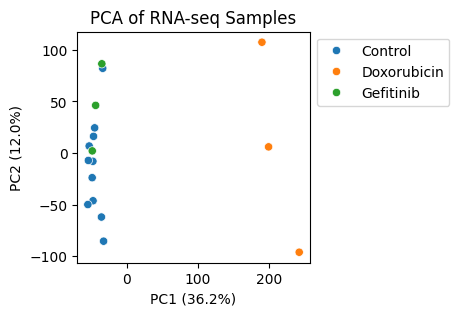

In [ ]:
plt.figure(figsize=(3, 3))
sns.scatterplot(

data=plot_df,

x="PC1", y="PC2",

hue="condition"

)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("plots/PCA_session2.png", dpi = 200)

plt.show()

**Solution**  
- Doxorubicin is expected to have a higher effect on gene expression, as the samples form a seperate cluster from the controls. Genifitib instead clusters with the control samples, so a smaller effect on gene expression is expected.
- Doxorubicin is expected to have more up- and downregulated genes than Genfinitib.

# Differential gene expression

Now you can perform differential gene expression analysis using the DEseq2 method. This method allows to find genes with significant expression differences (up- or downregulated) bewteen two conditions.
- Your goal is to investigate the effect of the drugs on cardiomyocyte differentiation. Which samples do you need to compare?
- Then, build you DEseq object(s) and run the analysis. *Make sure you use the raw counts for this (not the counts per million normalized counts used for PCA), since DEseq does it's own internal normalization method.*
- Analyse the output of your DEseq analysis. Does the number of differentially expressed genes match your expectiations from the PCA analysis?
- Look up the most up/downregulated genes between the conditions. Visualise the first 10 in a volcano plot or heatmap. Can you draw any conclusion from this about the drug effect?

**Solution**  
- We want to compare each drug with the control. Therefore, we need to do two seperate DE analysis, once Doxorubicin vs Ctrl and then Gefinitib vs Ctrl.

In [ ]:
drug = "Doxorubicin"

metadata_df_filtered_dox = metadata_table[metadata_table["treatment"].isin([drug, "Control"])]
counts_filtered_dox = filtered_count_table[metadata_df_filtered_dox.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_dox.T,
    metadata=metadata_df_filtered_dox,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_dox = DeseqStats(
    deseq_object, contrast=("treatment", "Doxorubicin", "Control")
)
stat_res_dox.summary()
results_df_dox = stat_res_dox.results_df

/tmp/ipython-input-3200602812.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  deseq_object = DeseqDataSet(
Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 44.21 seconds.

Fitting dispersion trend curve...
... done in 1.24 seconds.

Fitting MAP dispersions...
... done in 51.93 seconds.

Fitting LFCs...
... done in 33.80 seconds.

Calculating cook's distance...
... done in 0.18 seconds.

Replacing 167 outlier genes.

Fitting dispersions...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 1.15 seconds.

Fitting LFCs...
... done in 0.98 seconds.

Running Wald tests...
... done in 10.71 seconds.



Log2 fold change & Wald test p-value: treatment Doxorubicin vs Control
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P            51.338910       -0.086644  0.404943 -0.213966  0.830574   
MIR6859-1          4.578691        1.676120  0.845594  1.982181  0.047459   
LOC124900384       4.191673       -3.255476  1.409005 -2.310479  0.020862   
LOC729737        328.610335       -1.083885  0.390117 -2.778361  0.005463   
LOC100996442      47.854603        0.182055  0.411936  0.441948  0.658527   
...                     ...             ...       ...       ...       ...   
ND4           182211.265595        0.074764  0.215569  0.346821  0.728726   
ND5           125778.503921        0.115623  0.268401  0.430782  0.666627   
ND6            45108.469519        0.168373  0.201419  0.835934  0.403192   
CYTB          124055.191022        0.064987  0.214184  0.303416  0.761573   
TRNP             987.793621        1.713040  0.418877  4.089603  0.000043   

    

In [ ]:
# Get upregulated and downregulated genes
upregulated_genes_dox = results_df_dox[
    (results_df_dox["log2FoldChange"] > 2) & (results_df_dox["padj"] < 0.05)
]
downregulated_genes_dox = results_df_dox[
    (results_df_dox["log2FoldChange"] < -2) & (results_df_dox["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_dox.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_dox.shape[0]}")

    Upregulated genes: 3055
    Downregulated genes: 1314


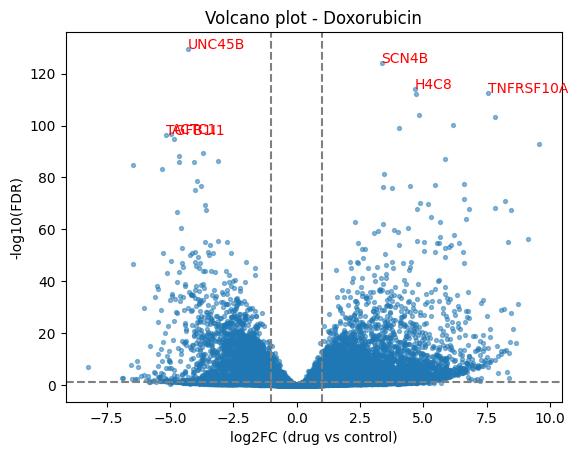

In [ ]:
plt.scatter(
    results_df_dox.log2FoldChange, -np.log10(results_df_dox.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")


up = results_df_dox[results_df_dox.log2FoldChange > 1].nsmallest(3, "padj")
down = results_df_dox[results_df_dox.log2FoldChange < -1].nsmallest(3, "padj")

for gene, r in up.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")
for gene, r in down.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")

plt.show()



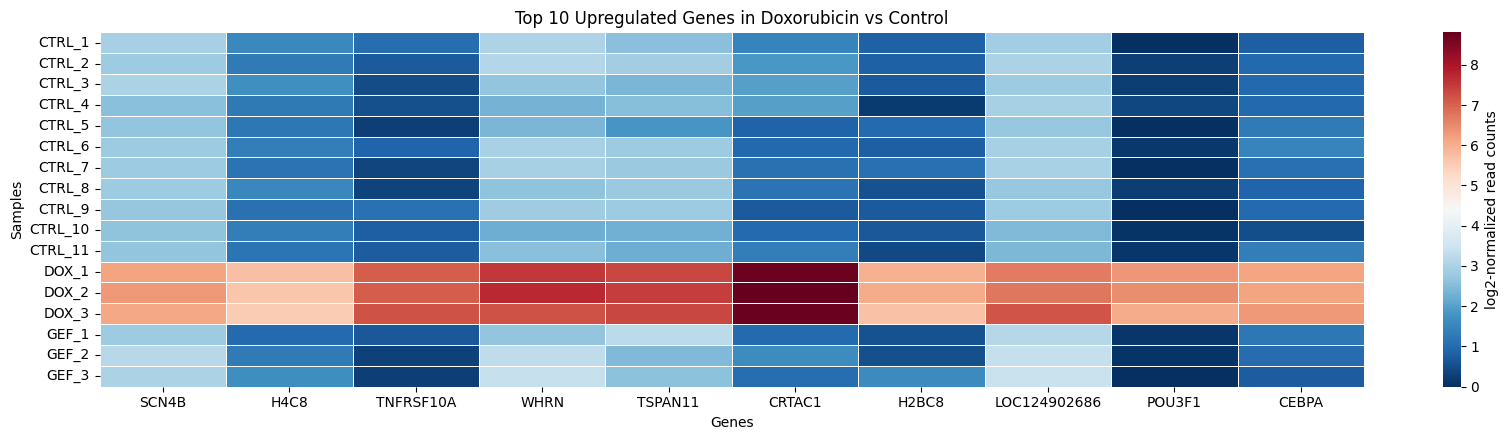

In [ ]:
gene_list = results_df_dox[results_df_dox.log2FoldChange > 1].nsmallest(10, "padj").index

subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]

plt.figure(figsize=(len(subset), 4.5))

sns.heatmap(subset, cmap="RdBu_r", linecolor = "white", linewidth = 0.5, cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Top 10 Upregulated Genes in Doxorubicin vs Control")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()

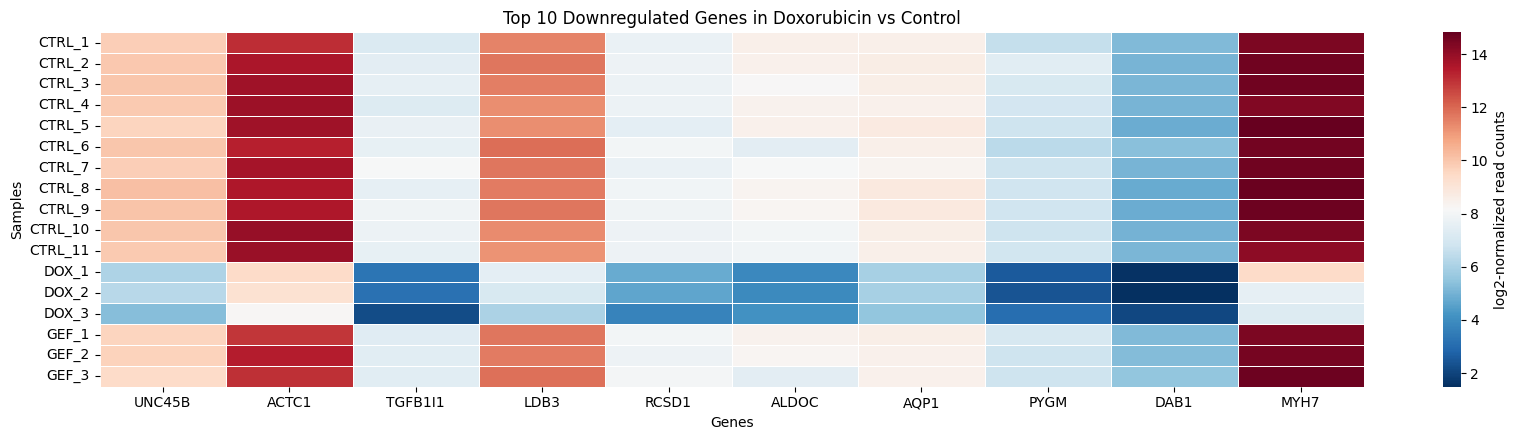

In [ ]:
gene_list = results_df_dox[results_df_dox.log2FoldChange < 1].nsmallest(10, "padj").index

subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]

plt.figure(figsize=(len(subset), 4.5))

sns.heatmap(subset, cmap="RdBu_r", linecolor = "white", linewidth = 0.5, cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Top 10 Downregulated Genes in Doxorubicin vs Control")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()

**Solution**  
Now repeat the analysis for Gefinitib





In [ ]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_table[metadata_table["treatment"].isin([drug, "Control"])]
counts_filtered_gef = filtered_count_table[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df




Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipython-input-1942930641.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  deseq_object = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 54.59 seconds.

Fitting dispersion trend curve...
... done in 2.65 seconds.

Fitting MAP dispersions...
... done in 40.63 seconds.

Fitting LFCs...
... done in 23.36 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 95 outlier genes.

Fitting dispersions...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 0.28 seconds.

Fitting LFCs...
... done in 0.22 seconds.

Running Wald tests...
... done in 7.56 seconds.



Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P            45.019869       -0.331790  0.409523 -0.810186  0.417833   
MIR6859-1          3.275361        0.782730  0.987807  0.792392  0.428132   
LOC124900384       4.295718       -0.745748  1.004548 -0.742372  0.457862   
LOC729737        356.604165        0.361360  0.302452  1.194770  0.232177   
LOC100996442      46.486884        0.559636  0.435215  1.285886  0.198483   
...                     ...             ...       ...       ...       ...   
ND4           170181.967212        0.252218  0.240110  1.050428  0.293521   
ND5           117310.524575        0.282055  0.276652  1.019529  0.307952   
ND6            41136.920981        0.198988  0.236175  0.842546  0.399483   
CYTB          115800.183916        0.240913  0.227706  1.058001  0.290055   
TRNP             590.362346       -0.150843  0.403098 -0.374209  0.708249   

      

In [ ]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")



    Upregulated genes: 0
    Downregulated genes: 15


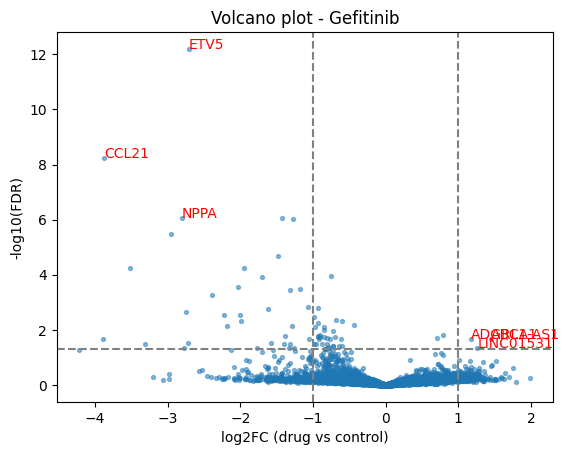

In [ ]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")


up = results_df_gef[results_df_gef.log2FoldChange > 1].nsmallest(3, "padj")
down = results_df_gef[results_df_gef.log2FoldChange < -1].nsmallest(3, "padj")

for gene, r in up.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")
for gene, r in down.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")

plt.show()



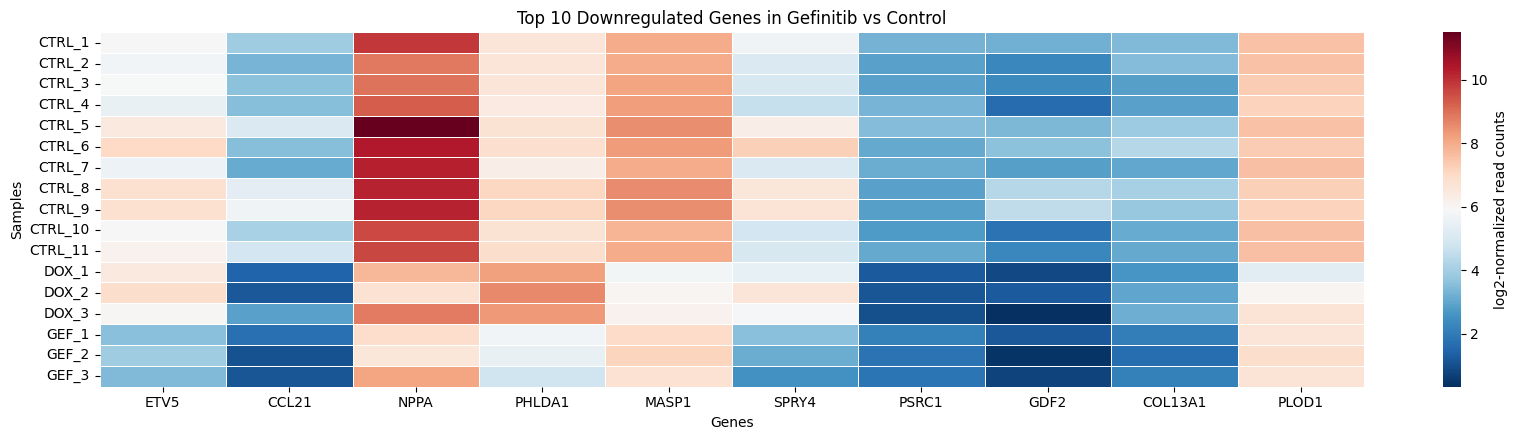

In [ ]:
gene_list = results_df_gef[results_df_gef.log2FoldChange < 1].nsmallest(10, "padj").index

subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]

plt.figure(figsize=(len(subset), 4.5))

sns.heatmap(subset, cmap="RdBu_r", linecolor = "white", linewidth = 0.5, cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Top 10 Downregulated Genes in Gefinitib vs Control")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()

**Solution**  
- There are many DE genes for Epirubicin, but only 11 DE genes for Gefinitib. Therefore, we would predict that Epirubicin is more toxic to cardiomyocites.
- The few genes that show as up/downregualted for Gefinitib are likely an artifact, since the still are more similarly expressed to control compared to Epirubicin treatment.


# Gene Ontology enrichment

Now, you can start interpreting the lists of genes you get from the DEseq analysis and learn if there are any biological pathways that are effected by the drug treatment.
- Use the cheat sheet to perform a GO enrichment analysis on the upregulated and dowregulated genes from your DEseq analysis. Which pathways can you see?
- Based on this analysis, do you think either of the drugs you tested are cardiotoxic? Which cellular mechanisms do they disrupt?

In [ ]:


GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]



In [ ]:
import time

go_upr_results_dox = {}
go_dwr_results_dox = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_dox.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_dox[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_dox.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_dox[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error



    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [ ]:


print(go_upr_results_dox)
print(go_dwr_results_dox)



{'GO_Biological_Process_2025':                         Gene_set  \
0     GO_Biological_Process_2025   
1     GO_Biological_Process_2025   
2     GO_Biological_Process_2025   
3     GO_Biological_Process_2025   
4     GO_Biological_Process_2025   
...                          ...   
3520  GO_Biological_Process_2025   
3521  GO_Biological_Process_2025   
3522  GO_Biological_Process_2025   
3523  GO_Biological_Process_2025   
3524  GO_Biological_Process_2025   

                                                   Term Overlap   P-value  \
0     Peripheral Nervous System Neuron Development (...     4/5  0.002386   
1     TRAIL-activated Apoptotic Signaling Pathway (G...     4/8  0.022713   
2     Cell Differentiation Involved in Metanephros D...     4/8  0.022713   
3     Regulation of Nephron Tubule Epithelial Cell D...     4/8  0.022713   
4         Sensory Perception of Sour Taste (GO:0050915)     4/8  0.022713   
...                                                 ...     ...       ... 

In [ ]:


for k, v in go_upr_results_dox.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")



GO_Biological_Process_2025: (3525, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (296, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (736, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


GO_Biological_Process_2025: (3103, 10)
GO_Cellular_Component_2025: (255, 10)
GO_Molecular_Function_2025: (626, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


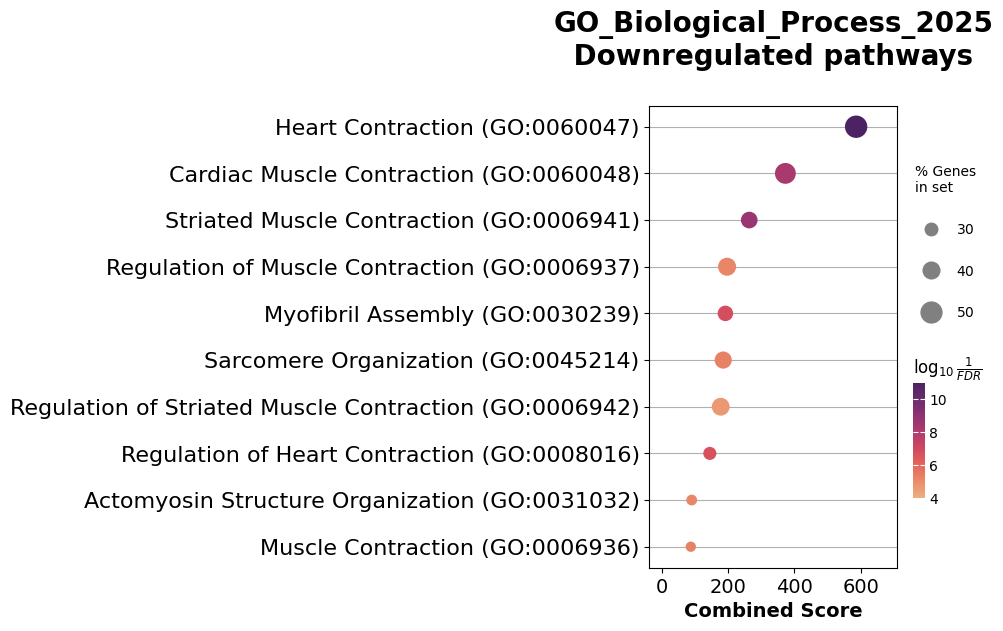

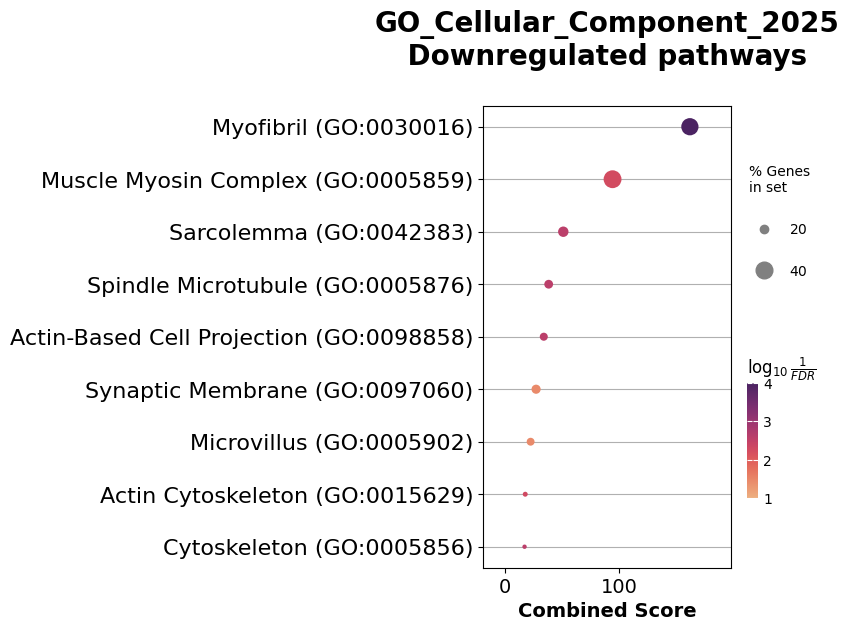

In [ ]:


for k, v in go_dwr_results_dox.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")



In [ ]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [ ]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


**Solution**
- Doxorubicin works by blocking Topoisomerase II, intercalating through the DNA and generating ROS. (DNA damage + oxidative stress → apoptosis + loss of contractile identity) This fits with the downregulated pathways which are mostly related to contraction, and the upregulated genes which suggest preparation for apoptosis (TNFRSF10A) and stress-induces transcriptional reprogramming, leading to loss of mature cardiomyocyte identity (CRTAC1)